# Jitto FSE Challenge
**Author:** Anirudh Navin Arbatti  
**Date:** July 2, 2025  
**Filename:** Jitto FSE Challenge Full Analysis and Solution - Anirudh Navin Arbatti.ipynb

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import os
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

# Introduction

For this project, I was tasked with building a model that can forecast the probability of unrest one
month in advance given unrest.csv, a dataset containing monthly indicators for 50 regions
over a 10-year period. I performed analysis of the features to gain an insight into which indicators had a strong correlation with unrest occurring the next month.

## Preliminary Analytics

In [26]:
INPUT_DATA_PATH = os.path.join(os.getcwd(),"Input")
input_file = os.path.join(INPUT_DATA_PATH, "unrest.csv")
OUTPUT_DATA_PATH = os.path.join(os.getcwd(),"Output")


In [27]:
# Read input file
df = pd.read_csv(input_file, parse_dates=["month"])
df = df.sort_values(['region_id', 'month']).reset_index(drop=True)

# Shift all features besides unrest_event down one
lag_features = ['gini_index','unemployment_rate','inflation_rate','media_sentiment_index','rainfall_deviation',
                'policy_instability_index','prior_unrest_count','population_density','food_price_index','fuel_subsidy_cut',
                'gov_approval','neighbor_unrest_prev']

for col in lag_features:
    df[f'{col}_lag1'] = df.groupby('region_id')[col].shift(1)
    df.drop(columns=[col], inplace=True)

# Drop rows with missing values
df = df.dropna(subset=[f'{col}_lag1' for col in lag_features])

df.head()

,region_id,month,unrest_event,gini_index_lag1,unemployment_rate_lag1,inflation_rate_lag1,media_sentiment_index_lag1,rainfall_deviation_lag1,policy_instability_index_lag1,prior_unrest_count_lag1,population_density_lag1,food_price_index_lag1,fuel_subsidy_cut_lag1,gov_approval_lag1,neighbor_unrest_prev_lag1
1,R1,2023-02-01,0,0.537,9.69,1.33,0.372,1.80,2.0,0.00,108.9,103.7,0.0,0.00,0.0
2,R1,2023-03-01,0,0.556,9.14,2.21,-0.407,-1.39,0.0,1.00,274.6,117.9,0.0,0.00,1.0
3,R1,2023-04-01,0,0.542,8.79,2.67,-0.670,0.64,2.0,0.70,112.5,114.4,0.0,0.00,2.0
4,R1,2023-05-01,0,0.539,10.38,2.37,-0.006,0.96,0.0,0.49,143.8,106.1,0.0,0.00,3.0
5,R1,2023-06-01,0,0.517,9.33,3.17,0.638,0.65,0.0,0.34,197.8,109.8,0.0,0.07,0.0


The counts of the unrest_event by region:

In [28]:
target_counts = df.groupby("region_id")["unrest_event"].value_counts().unstack(fill_value=0)

# Rename columns
target_counts.columns = ["unrest_event_0_count", "unrest_event_1_count"]

# Add total column
target_counts["total"] = target_counts["unrest_event_0_count"] + target_counts["unrest_event_1_count"]

# Sort by target_1_count in descending order
target_counts_sorted = target_counts.sort_values(by="unrest_event_1_count", ascending=False)

print(target_counts_sorted)

           unrest_event_0_count  unrest_event_1_count  total
region_id                                                   
R1                           76                    43    119
R9                           78                    41    119
R16                          80                    39    119
R23                          84                    35    119
R31                          84                    35    119
R39                          85                    34    119
R6                           86                    33    119
R28                          87                    32    119
R46                          87                    32    119
R50                          92                    27    119
R37                          92                    27    119
R21                          93                    26    119
R22                          94                    25    119
R7                           94                    25    119
R45                     

In [29]:
df["unrest_event"].value_counts()

unrest_event
0    4968
1     982
Name: count, dtype: int64

Plot a stacked bar graph representing unrest event counts by region:

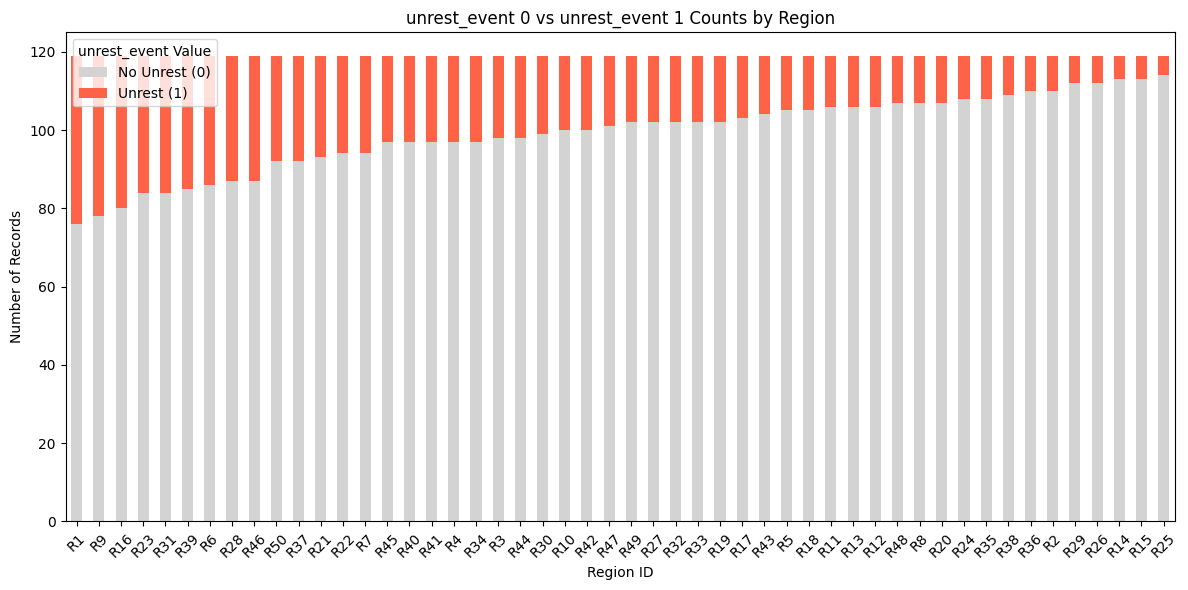

In [30]:
plot_data = target_counts_sorted[["unrest_event_0_count", "unrest_event_1_count"]]

# Plot
plot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=['lightgray', 'tomato']  # or choose any colors you like
)

plt.xlabel("Region ID")
plt.ylabel("Number of Records")
plt.title("unrest_event 0 vs unrest_event 1 Counts by Region")
plt.xticks(rotation=45)
plt.legend(title="unrest_event Value", labels=["No Unrest (0)", "Unrest (1)"])
plt.tight_layout()
plt.show()

The occurrence of unrest varies significantly by region, and so a model should learn region specific data in order to make good predictions.

Next, I plotted the features against unrest_event to understand how correlated particular indicators are with unrest happening the next month:

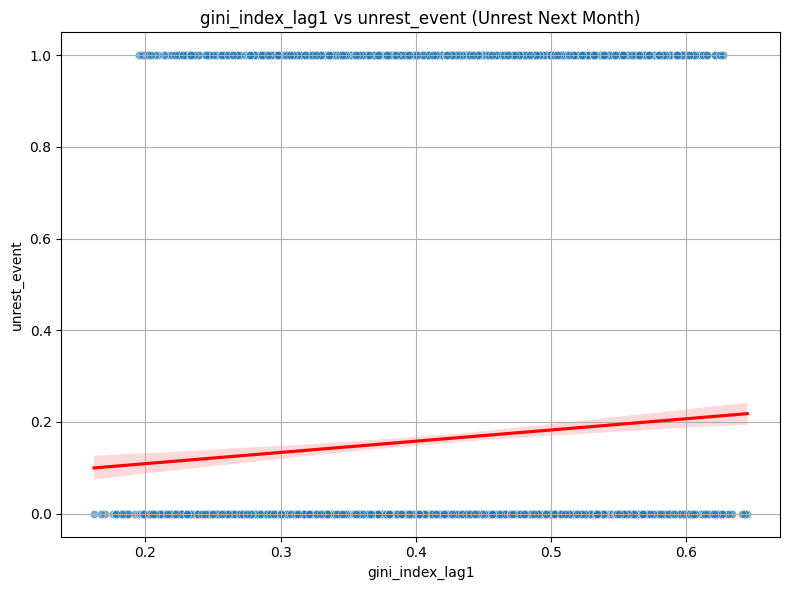

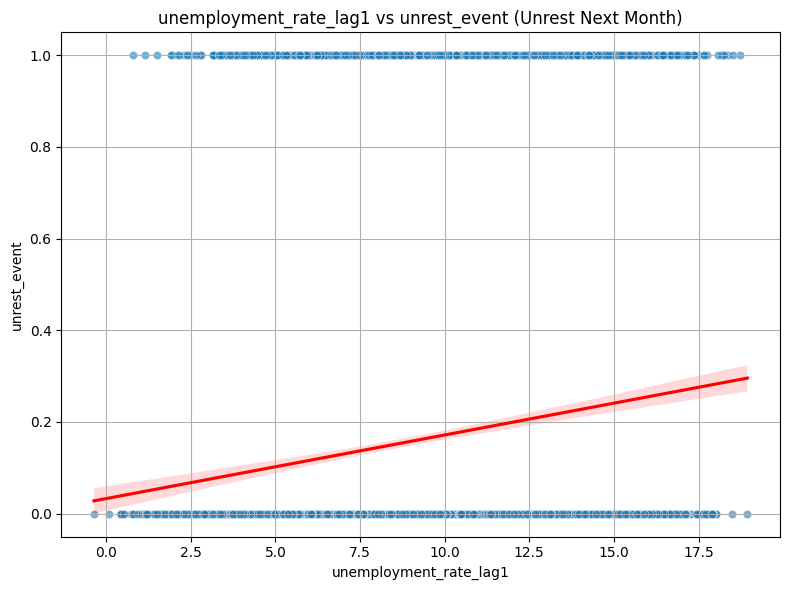

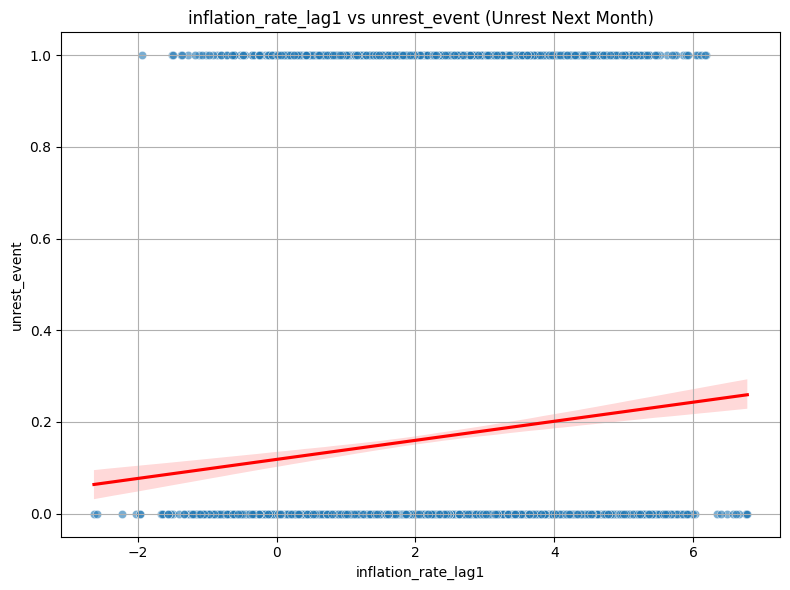

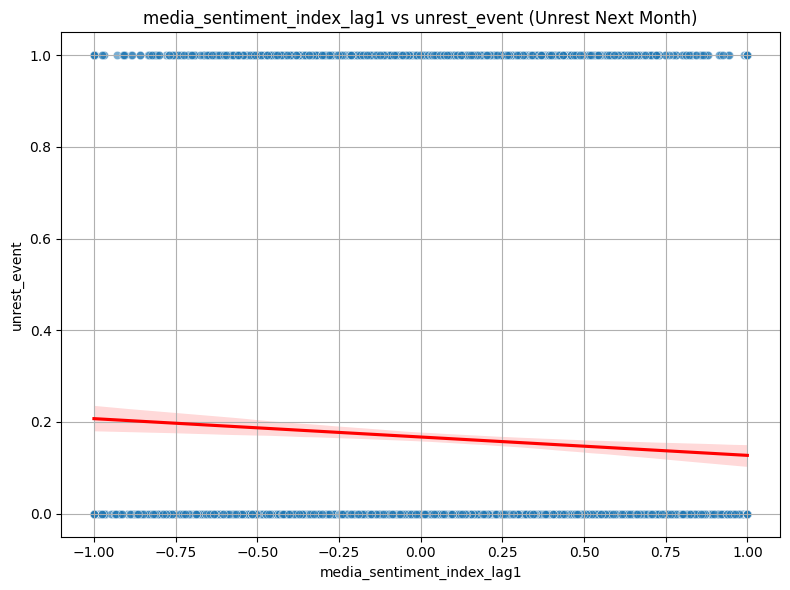

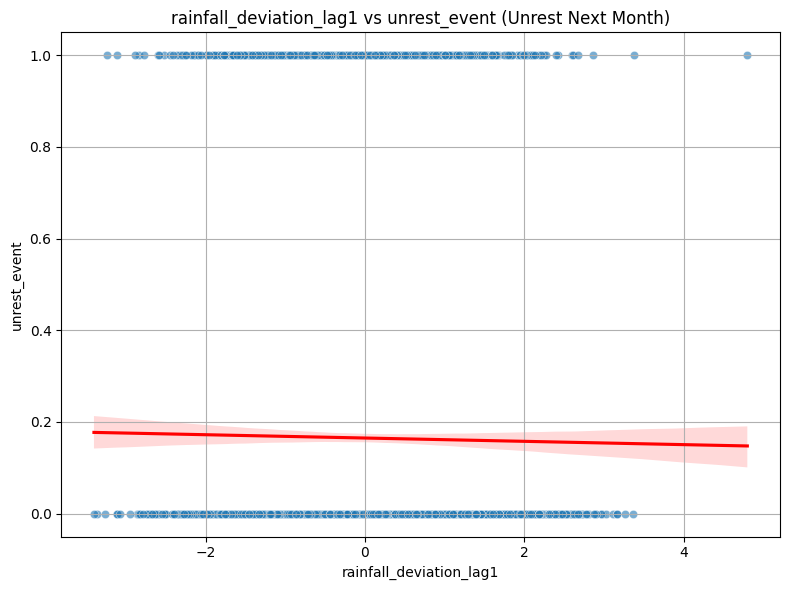

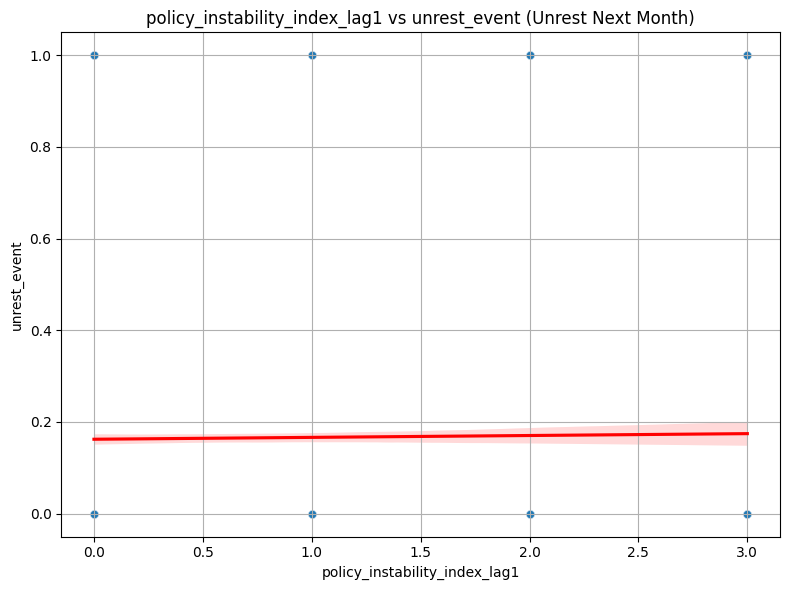

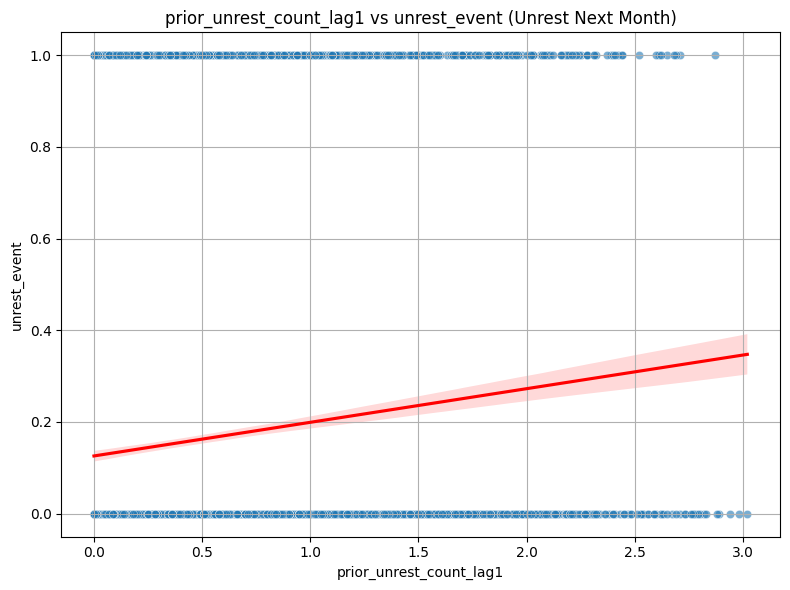

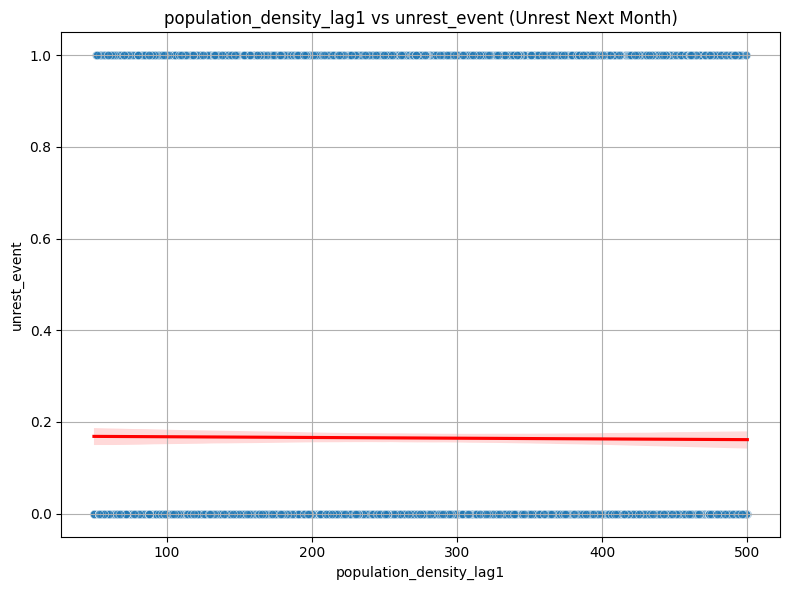

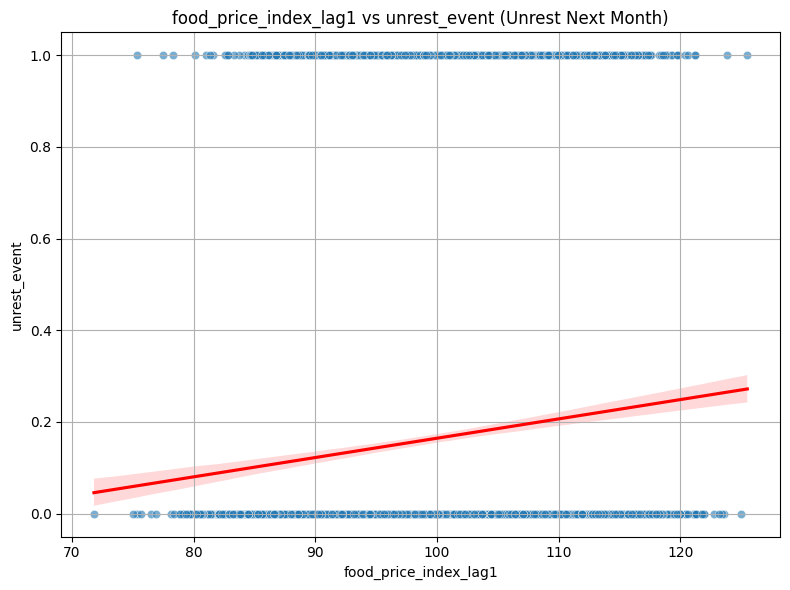

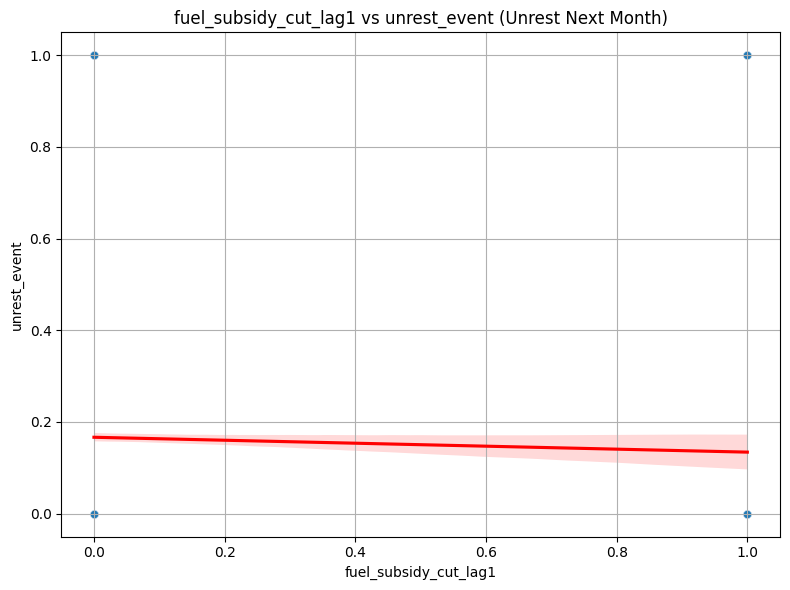

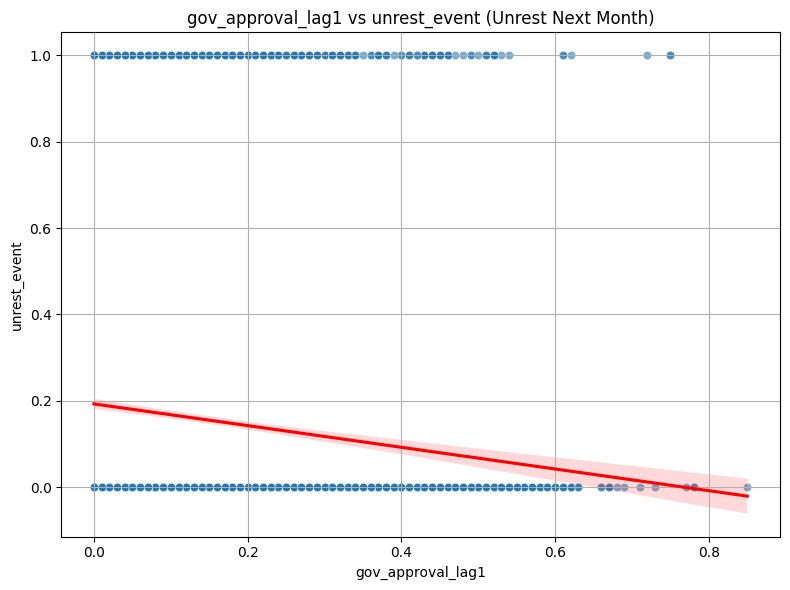

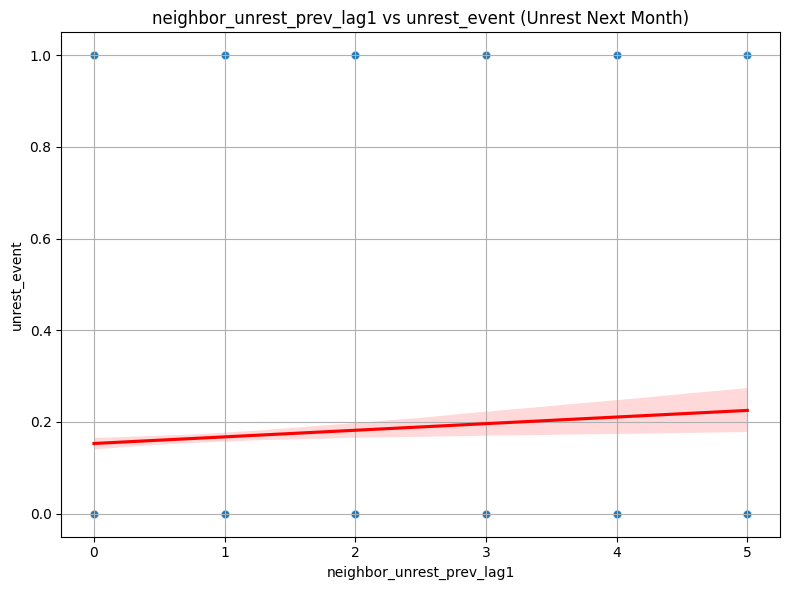

In [31]:
features = [
    'gini_index_lag1',
    'unemployment_rate_lag1',
    'inflation_rate_lag1',
    'media_sentiment_index_lag1',
    'rainfall_deviation_lag1',
    'policy_instability_index_lag1',
    'prior_unrest_count_lag1',
    'population_density_lag1',
    'food_price_index_lag1',
    'fuel_subsidy_cut_lag1',
    'gov_approval_lag1',
    'neighbor_unrest_prev_lag1'
]

# Plot each feature against the target
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=feature, y='unrest_event', alpha=0.6)
    sns.regplot(data=df, x=feature, y='unrest_event', scatter=False, color='red')
    plt.title(f'{feature} vs unrest_event (Unrest Next Month)')
    plt.xlabel(feature)
    plt.ylabel('unrest_event')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Certain features are more correlated with unrest than others, in particular, inflation, unemployment, prior unrest, and the food price index.

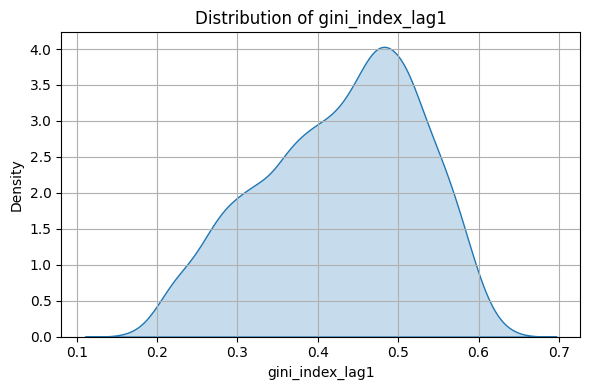

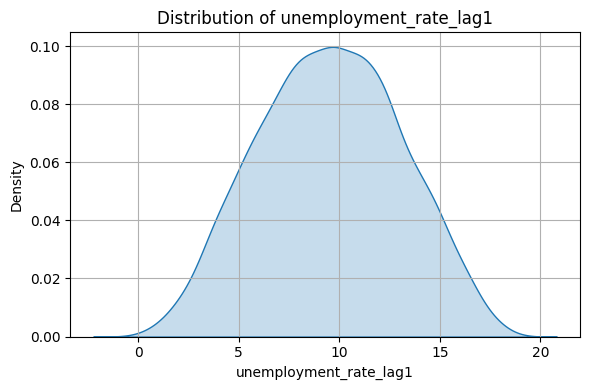

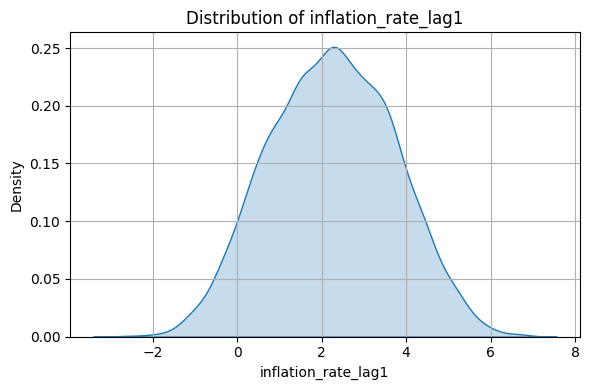

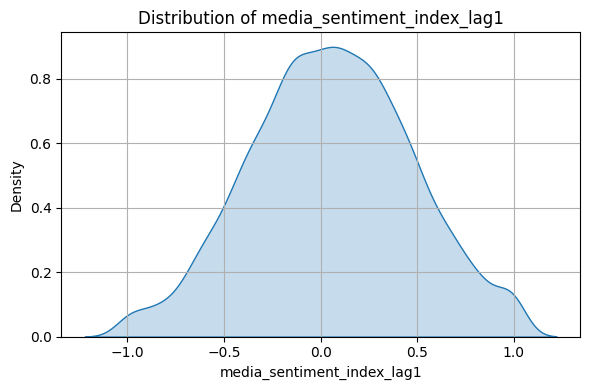

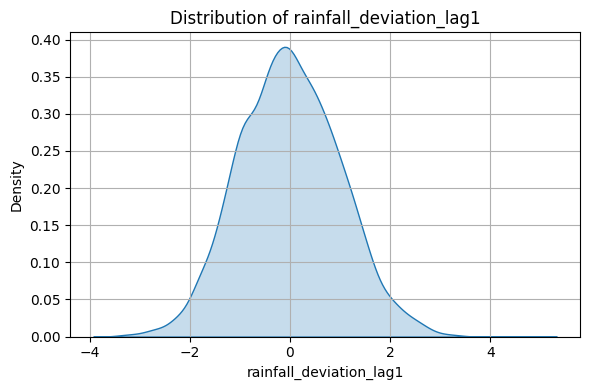

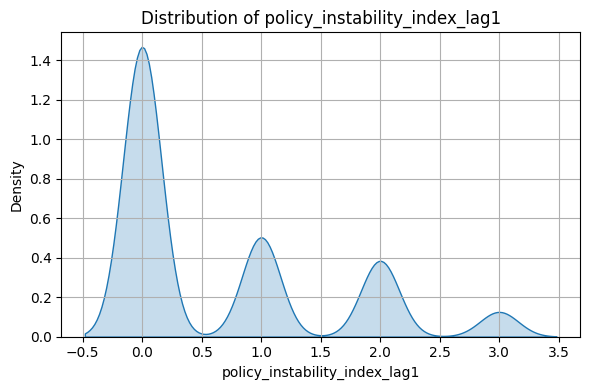

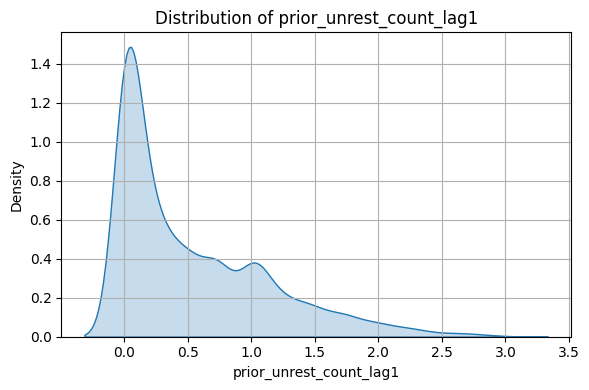

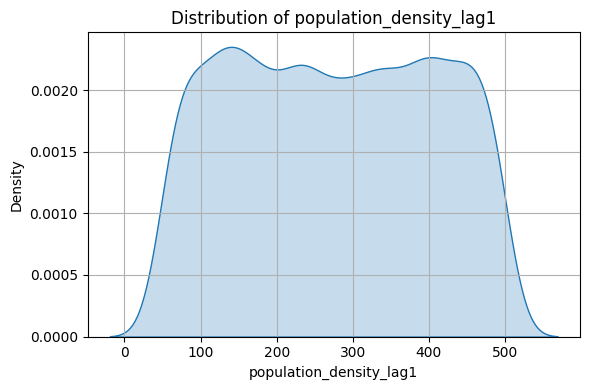

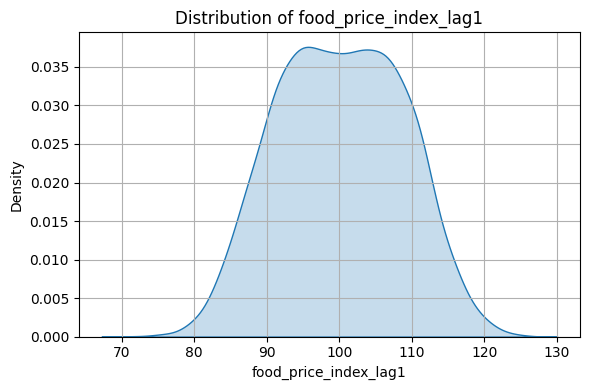

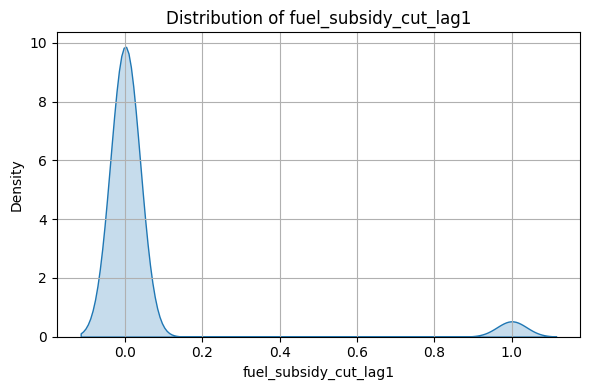

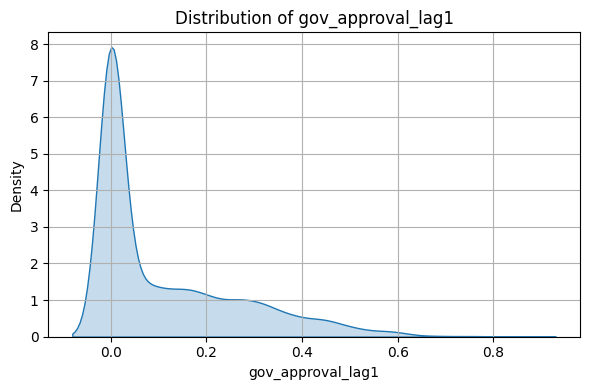

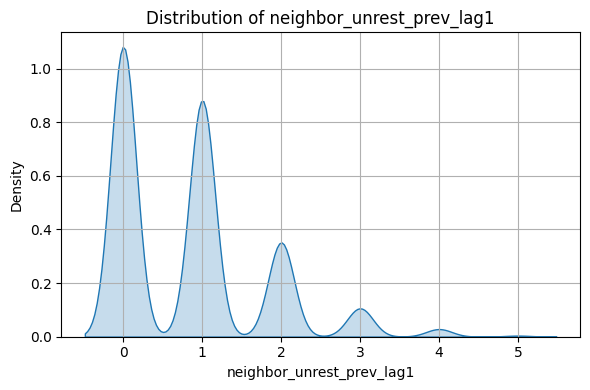

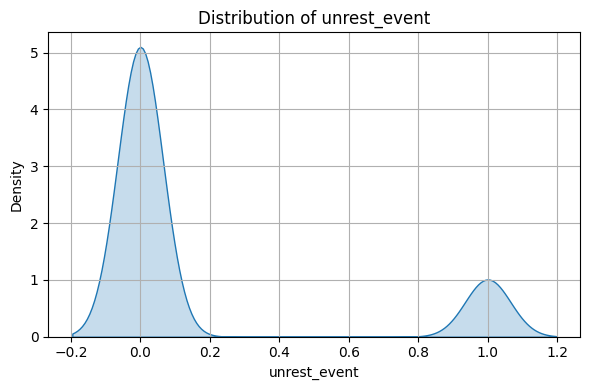

In [32]:
features = [
    'gini_index_lag1',
    'unemployment_rate_lag1',
    'inflation_rate_lag1',
    'media_sentiment_index_lag1',
    'rainfall_deviation_lag1',
    'policy_instability_index_lag1',
    'prior_unrest_count_lag1',
    'population_density_lag1',
    'food_price_index_lag1',
    'fuel_subsidy_cut_lag1',
    'gov_approval_lag1',
    'neighbor_unrest_prev_lag1',
    'unrest_event'
]

# Plot KDEs for each feature
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df[feature], fill=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Seeing the distribution of the features was also extremely helpful to understand how the data I'll be working with looks like. It also helped me to see which features can be considered categorical vs. numerical.

Next, I wanted to see which months have the most unrest events, to see if certain months are strongly correlated with unrest, or if it is equally distributed throughout the year.

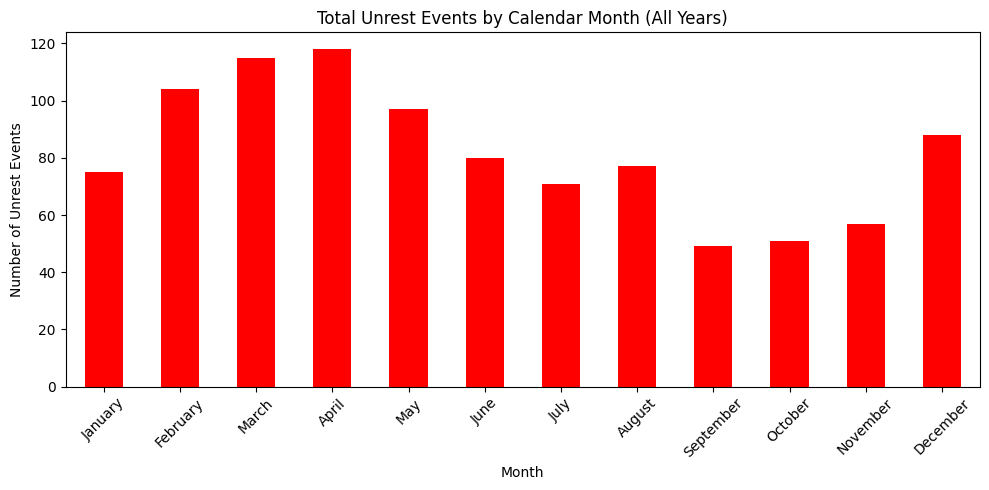

In [33]:
# Convert 'month' to datetime
df['month'] = pd.to_datetime(df['month'])

# Extract month names
df['month_name'] = df['month'].dt.month_name()

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

# Filter for unrest events and count per month
unrest_per_month = df[df['unrest_event'] == 1]['month_name'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
unrest_per_month.plot(kind='bar', color='red')
plt.xlabel('Month')
plt.ylabel('Number of Unrest Events')
plt.title('Total Unrest Events by Calendar Month (All Years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From this graph, it appears that the occurrence of unrest has a clear temporal pattern, peaking during the first half of the year, and lowest during the mid second half of the year.

# Approach 1: Baseline Assessment

To establish a point of comparison for other approaches, I began with a set of baseline models. These simple models served as a reference to assess whether tuning the model or feature engineering offers meaningful improvements in predictive performance. I evaluated the performance of four models:

* Random Forest
* Naive Bayes
* SVM
* Logistic Regression





In [34]:
df.head()

,region_id,month,unrest_event,gini_index_lag1,unemployment_rate_lag1,inflation_rate_lag1,media_sentiment_index_lag1,rainfall_deviation_lag1,policy_instability_index_lag1,prior_unrest_count_lag1,population_density_lag1,food_price_index_lag1,fuel_subsidy_cut_lag1,gov_approval_lag1,neighbor_unrest_prev_lag1,month_name
1,R1,2023-02-01,0,0.537,9.69,1.33,0.372,1.80,2.0,0.00,108.9,103.7,0.0,0.00,0.0,February
2,R1,2023-03-01,0,0.556,9.14,2.21,-0.407,-1.39,0.0,1.00,274.6,117.9,0.0,0.00,1.0,March
3,R1,2023-04-01,0,0.542,8.79,2.67,-0.670,0.64,2.0,0.70,112.5,114.4,0.0,0.00,2.0,April
4,R1,2023-05-01,0,0.539,10.38,2.37,-0.006,0.96,0.0,0.49,143.8,106.1,0.0,0.00,3.0,May
5,R1,2023-06-01,0,0.517,9.33,3.17,0.638,0.65,0.0,0.34,197.8,109.8,0.0,0.07,0.0,June


In [35]:
X = df.drop(columns=['unrest_event', 'month', 'month_name'])

y = df['unrest_event']  # Label

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Must separate categorical features from numerical for encoding purposes
cat_columns = ['region_id', 'fuel_subsidy_cut_lag1']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Normalize numerical features
        ]), X_train.select_dtypes(include=['float64', 'int64']).columns),  
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing categorical data
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
        ]), cat_columns)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # transform just like I transformed X_train

print(f'X_train_processed Shape: {X_train_processed.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test_processed Shape: {X_test_processed.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train_processed Shape: (5355, 64)
y_train: (5355,)
X_test_processed Shape: (595, 64)
y_test Shape: (595,)


## Random Forest

In [36]:
# Instantiate and fit the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)

# Find the best threshold
y_probs = rf_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


Best Threshold: 0.26
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       500
           1       0.25      0.29      0.27        95

    accuracy                           0.75       595
   macro avg       0.56      0.57      0.56       595
weighted avg       0.76      0.75      0.76       595



## Naive Bayes

In [37]:
# Instantiate and fit the model
nb_model = GaussianNB()
nb_model.fit(X_train_processed, y_train)

# Find the best threshold
y_probs = nb_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


Best Threshold: 0.9999999269227251
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       500
           1       0.36      0.32      0.34        95

    accuracy                           0.80       595
   macro avg       0.61      0.60      0.61       595
weighted avg       0.79      0.80      0.79       595



## SVM

In [38]:
# Instantiate and fit the model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_processed, y_train)

# Find the best threshold
y_probs = svm_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

Best Threshold: 0.15859093358159068
              precision    recall  f1-score   support

           0       0.87      0.48      0.62       500
           1       0.18      0.61      0.28        95

    accuracy                           0.50       595
   macro avg       0.53      0.55      0.45       595
weighted avg       0.76      0.50      0.57       595



## Logistic Regression

In [39]:
# Instantiate and fit the model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_processed, y_train)

# Find the best threshold
y_probs = lr_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

Best Threshold: 0.22205844882847814
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       500
           1       0.30      0.43      0.35        95

    accuracy                           0.75       595
   macro avg       0.59      0.62      0.60       595
weighted avg       0.79      0.75      0.76       595



## Analysis

All four models performed poorly in terms of precision and recall. I attributed this to class imbalance in the data, where unrest events are relatively rare (as we saw in the preliminary analysis). This imbalance made it difficult for models to learn the patterns required to identify unrest. Additionally, performance can be improved by feature engineering and/or excluding non-predictive features.

I also realized that **the ideal model should have a high recall value**, as minimizing false negatives is important when considering that I'm building a model to predict the probability of unrest for the next month, and erring on the side of caution is better than downplaying the risk of unrest.

In the next approach, I applied SMOTE to address class imbalance by synthetically generating samples for the minority class. This ensured the training set is more balanced with respect to the unrest_event label, helping the model better learn meaningful patterns and make more accurate predictions.

# Approach 2: Using SMOTE

In this approach, I use SMOTE to address class imbalance and assess the performance of the same four models

In [40]:
df.head()

,region_id,month,unrest_event,gini_index_lag1,unemployment_rate_lag1,inflation_rate_lag1,media_sentiment_index_lag1,rainfall_deviation_lag1,policy_instability_index_lag1,prior_unrest_count_lag1,population_density_lag1,food_price_index_lag1,fuel_subsidy_cut_lag1,gov_approval_lag1,neighbor_unrest_prev_lag1,month_name
1,R1,2023-02-01,0,0.537,9.69,1.33,0.372,1.80,2.0,0.00,108.9,103.7,0.0,0.00,0.0,February
2,R1,2023-03-01,0,0.556,9.14,2.21,-0.407,-1.39,0.0,1.00,274.6,117.9,0.0,0.00,1.0,March
3,R1,2023-04-01,0,0.542,8.79,2.67,-0.670,0.64,2.0,0.70,112.5,114.4,0.0,0.00,2.0,April
4,R1,2023-05-01,0,0.539,10.38,2.37,-0.006,0.96,0.0,0.49,143.8,106.1,0.0,0.00,3.0,May
5,R1,2023-06-01,0,0.517,9.33,3.17,0.638,0.65,0.0,0.34,197.8,109.8,0.0,0.07,0.0,June


In [41]:
X = df.drop(columns=['unrest_event', 'month', 'month_name'])

y = df['unrest_event']  # Label

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Must separate categorical features from numerical for encoding purposes
cat_columns = ['region_id', 'fuel_subsidy_cut_lag1']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Normalize numerical features
        ]), X_train.select_dtypes(include=['float64', 'int64']).columns),  
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing categorical data
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
        ]), cat_columns)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # transform just like I transformed X_train

# Apply smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

print(f'X_train_processed Shape: {X_resampled.shape}')
print(f'y_train: {y_resampled.shape}')
print(f'X_test_processed Shape: {X_test_processed.shape}')
print(f'y_test Shape: {y_test.shape}')

# Count the new distribution of labels after applying SMOTE
print(f"y_resampled dataset label counter: {Counter(y_resampled)}")
print(f"y_test dataset label counter: {Counter(y_test)}")

X_train_processed Shape: (8936, 64)
y_train: (8936,)
X_test_processed Shape: (595, 64)
y_test Shape: (595,)
y_resampled dataset label counter: Counter({1: 4468, 0: 4468})
y_test dataset label counter: Counter({0: 500, 1: 95})


## Random Forest

In [42]:
# Instantiate and fit the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = rf_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


Best Threshold: 0.34
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       500
           1       0.23      0.41      0.30        95

    accuracy                           0.69       595
   macro avg       0.55      0.58      0.55       595
weighted avg       0.77      0.69      0.72       595



## Naive Bayes

In [32]:
# Instantiate and fit the model
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = nb_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


Best Threshold: 0.9999999901869003
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       500
           1       0.34      0.33      0.33        95

    accuracy                           0.79       595
   macro avg       0.61      0.60      0.60       595
weighted avg       0.79      0.79      0.79       595



## SVM

In [43]:
# Instantiate and fit the model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = svm_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

Best Threshold: 0.11346770742451759
              precision    recall  f1-score   support

           0       0.93      0.29      0.44       500
           1       0.19      0.88      0.32        95

    accuracy                           0.39       595
   macro avg       0.56      0.59      0.38       595
weighted avg       0.81      0.39      0.42       595



## Logistic Regression

In [44]:
# Instantiate and fit the model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = lr_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

Best Threshold: 0.6250219714453868
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       500
           1       0.32      0.39      0.35        95

    accuracy                           0.77       595
   macro avg       0.60      0.62      0.61       595
weighted avg       0.79      0.77      0.78       595



## Analysis

Most of the models improved in terms of recall for the positive class, unrest_event = 1, besides Logistic Regression. This is, however, at the cost of other metrics. For example, recall for unrest_event = 0 went down in all models besides Logistic Regression. The accuracy also decreased in the first 3 models.

Despite the improvement in recall for the positive class (unrest_event = 1), the overall evaluation metrics remained suboptimal, suggesting that further feature engineering is needed to enhance the models' performance.

# Approach 3: Application of Feature Engineering

In [45]:
# Read input file
df = pd.read_csv(input_file, parse_dates=["month"])
df = df.sort_values(['region_id', 'month']).reset_index(drop=True)

# Shift all features besides unrest_event down one
lag_features = ['gini_index','unemployment_rate','inflation_rate','media_sentiment_index','rainfall_deviation',
                'policy_instability_index','prior_unrest_count','population_density','food_price_index','fuel_subsidy_cut',
                'gov_approval','neighbor_unrest_prev']

for col in lag_features:
    df[f'{col}_lag1'] = df.groupby('region_id')[col].shift(1)
    df.drop(columns=[col], inplace=True)

# Drop rows with missing values
df = df.dropna(subset=[f'{col}_lag1' for col in lag_features])

df.head()

,region_id,month,unrest_event,gini_index_lag1,unemployment_rate_lag1,inflation_rate_lag1,media_sentiment_index_lag1,rainfall_deviation_lag1,policy_instability_index_lag1,prior_unrest_count_lag1,population_density_lag1,food_price_index_lag1,fuel_subsidy_cut_lag1,gov_approval_lag1,neighbor_unrest_prev_lag1
1,R1,2023-02-01,0,0.537,9.69,1.33,0.372,1.80,2.0,0.00,108.9,103.7,0.0,0.00,0.0
2,R1,2023-03-01,0,0.556,9.14,2.21,-0.407,-1.39,0.0,1.00,274.6,117.9,0.0,0.00,1.0
3,R1,2023-04-01,0,0.542,8.79,2.67,-0.670,0.64,2.0,0.70,112.5,114.4,0.0,0.00,2.0
4,R1,2023-05-01,0,0.539,10.38,2.37,-0.006,0.96,0.0,0.49,143.8,106.1,0.0,0.00,3.0
5,R1,2023-06-01,0,0.517,9.33,3.17,0.638,0.65,0.0,0.34,197.8,109.8,0.0,0.07,0.0


## Feature Engineering

I added two features:
* rolling_unrest_3mo - a measure of recent (within 3 months) unrest activity, caluclated by averaging the number of unrest events over the last 3 months 
* months_since_unrest - the number of months since the last unrest event occurred; the motivator for this feature was the idea that unrest events cluster together and so recent unrest is predictive of future unrest

In [46]:
df['rolling_unrest_3mo'] = (
    df.groupby('region_id')['unrest_event']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

def months_since_last_unrest(series):
    counter = 0
    result = []
    for val in series:
        if val == 1:
            counter = 0
        else:
            counter += 1
        result.append(counter)
    return pd.Series(result, index=series.index)

df['months_since_unrest'] = (
    df.groupby('region_id', group_keys=False)['unrest_event']
    .apply(months_since_last_unrest)
)

df['month_num'] = df['month'].dt.month.astype(str)


df.head()

,region_id,month,unrest_event,gini_index_lag1,unemployment_rate_lag1,inflation_rate_lag1,media_sentiment_index_lag1,rainfall_deviation_lag1,policy_instability_index_lag1,prior_unrest_count_lag1,population_density_lag1,food_price_index_lag1,fuel_subsidy_cut_lag1,gov_approval_lag1,neighbor_unrest_prev_lag1,rolling_unrest_3mo,months_since_unrest,month_num
1,R1,2023-02-01,0,0.537,9.69,1.33,0.372,1.80,2.0,0.00,108.9,103.7,0.0,0.00,0.0,0.0,1,2
2,R1,2023-03-01,0,0.556,9.14,2.21,-0.407,-1.39,0.0,1.00,274.6,117.9,0.0,0.00,1.0,0.0,2,3
3,R1,2023-04-01,0,0.542,8.79,2.67,-0.670,0.64,2.0,0.70,112.5,114.4,0.0,0.00,2.0,0.0,3,4
4,R1,2023-05-01,0,0.539,10.38,2.37,-0.006,0.96,0.0,0.49,143.8,106.1,0.0,0.00,3.0,0.0,4,5
5,R1,2023-06-01,0,0.517,9.33,3.17,0.638,0.65,0.0,0.34,197.8,109.8,0.0,0.07,0.0,0.0,5,6


## Create Holdout Set for Evaluation

This holdout set can be used for evaluating the performance of the model after training

In [47]:
holdout_cutoff_start = pd.Timestamp('1/1/2032')
holdout_cutoff_end = pd.Timestamp('1/1/2032')
holdout_mask = (df['month'] >= holdout_cutoff_start) & (df['month'] <= holdout_cutoff_end)
df_holdout = df[holdout_mask].copy()
df_holdout.to_csv(os.path.join(INPUT_DATA_PATH, "unrest_hold_out.csv"), index=False)
del df_holdout

df_dev = df[~holdout_mask].copy()
df_dev.head()

,region_id,month,unrest_event,gini_index_lag1,unemployment_rate_lag1,inflation_rate_lag1,media_sentiment_index_lag1,rainfall_deviation_lag1,policy_instability_index_lag1,prior_unrest_count_lag1,population_density_lag1,food_price_index_lag1,fuel_subsidy_cut_lag1,gov_approval_lag1,neighbor_unrest_prev_lag1,rolling_unrest_3mo,months_since_unrest,month_num
1,R1,2023-02-01,0,0.537,9.69,1.33,0.372,1.80,2.0,0.00,108.9,103.7,0.0,0.00,0.0,0.0,1,2
2,R1,2023-03-01,0,0.556,9.14,2.21,-0.407,-1.39,0.0,1.00,274.6,117.9,0.0,0.00,1.0,0.0,2,3
3,R1,2023-04-01,0,0.542,8.79,2.67,-0.670,0.64,2.0,0.70,112.5,114.4,0.0,0.00,2.0,0.0,3,4
4,R1,2023-05-01,0,0.539,10.38,2.37,-0.006,0.96,0.0,0.49,143.8,106.1,0.0,0.00,3.0,0.0,4,5
5,R1,2023-06-01,0,0.517,9.33,3.17,0.638,0.65,0.0,0.34,197.8,109.8,0.0,0.07,0.0,0.0,5,6


## Split Into Test and Train Sets

I found that time-based test-train split would be better suited for this problem to preserve the temporal integrity of the dataset

In [48]:
# Create time-based cutoff for splitting
cutoff = pd.Timestamp('12/1/2030')
train_mask = df_dev['month'] < cutoff

features = ['gini_index_lag1','unemployment_rate_lag1','inflation_rate_lag1','media_sentiment_index_lag1','rainfall_deviation_lag1',
            'policy_instability_index_lag1','prior_unrest_count_lag1','population_density_lag1','food_price_index_lag1',
            'fuel_subsidy_cut_lag1','gov_approval_lag1','neighbor_unrest_prev_lag1',
            'rolling_unrest_3mo', 'month_num', 'months_since_unrest']

X = df_dev[features]
y = df_dev['unrest_event']

# Apply cutoff to split into train and test sets
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]
print (X_train.shape)
print (X_test.shape)


(4700, 15)
(1200, 15)


## Preprocessing + SMOTE

In [49]:
# Categorical columns to be one-hot encoded
cat_columns = ['fuel_subsidy_cut_lag1', 'month_num']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())  # Normalization
        ]), X_train.select_dtypes(include=['float64', 'int64']).columns),  
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encoding
        ]), cat_columns)
    ]
)

# Fit/transform X_train and X_test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get numeric feature names (for feature importance analysis)
num_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(num_columns)

# Get categorical feature names
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_columns)

# Combine them
feature_names = np.concatenate([num_features, cat_features])
print(feature_names)

# Save the preprocessor
joblib.dump(preprocessor, os.path.join(OUTPUT_DATA_PATH,'preprocessor.pkl'))

['gini_index_lag1' 'unemployment_rate_lag1' 'inflation_rate_lag1'
 'media_sentiment_index_lag1' 'rainfall_deviation_lag1'
 'policy_instability_index_lag1' 'prior_unrest_count_lag1'
 'population_density_lag1' 'food_price_index_lag1' 'fuel_subsidy_cut_lag1'
 'gov_approval_lag1' 'neighbor_unrest_prev_lag1' 'rolling_unrest_3mo'
 'months_since_unrest' 'fuel_subsidy_cut_lag1_0.0'
 'fuel_subsidy_cut_lag1_1.0' 'month_num_1' 'month_num_10' 'month_num_11'
 'month_num_12' 'month_num_2' 'month_num_3' 'month_num_4' 'month_num_5'
 'month_num_6' 'month_num_7' 'month_num_8' 'month_num_9']


['C:\\Users\\anarb\\Rudy\\Personal\\Jitto Take Home Assessment\\Output\\preprocessor.pkl']

In [50]:
# Balance training set with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)
print(X_resampled.shape)
print(y_resampled.shape)

(7816, 28)
(7816,)


## Random Forest

In [51]:
# Instantiate and fit the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Save model
joblib.dump(rf_model, os.path.join(OUTPUT_DATA_PATH,'rf_model.pkl'))

# Find the best threshold
y_probs = rf_model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


Best Threshold: 0.83
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1015
           1       1.00      0.99      1.00       185

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



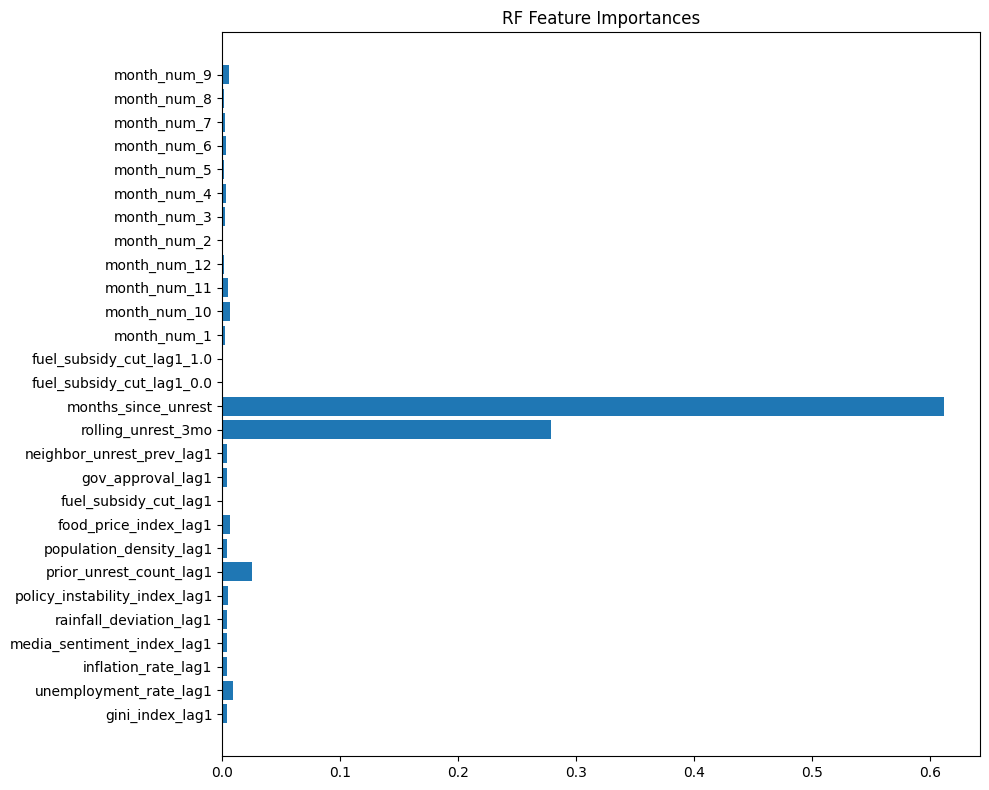

In [52]:
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances)
plt.title("RF Feature Importances")
plt.tight_layout()
plt.show()

## Naive Bayes

In [53]:
# Instantiate and fit the model
model = GaussianNB()
model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))


Best Threshold: 0.012863367096427535
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1015
           1       1.00      0.99      1.00       185

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



## SVM

In [54]:
# Instantiate and fit the model
model = SVC(probability=True, random_state=42)
model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

Best Threshold: 0.5248408730564265
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1015
           1       0.78      0.82      0.80       185

    accuracy                           0.94      1200
   macro avg       0.87      0.89      0.88      1200
weighted avg       0.94      0.94      0.94      1200



## Logistic Regression

In [55]:
# Instantiate and fit the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_resampled, y_resampled)

# Find the best threshold
y_probs = model.predict_proba(X_test_processed)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores for each threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

# Find the best threshold that maximizes F1 score
best_thresh = thresh[np.argmax(f1_scores)]

print(f'Best Threshold: {best_thresh}')

# Predict based on the best threshold
y_pred = (y_probs > best_thresh).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

Best Threshold: 0.7659374441040987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1015
           1       1.00      0.99      1.00       185

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



## Evaluating Random Forest on Holdout Set

In [56]:
df_holdout = pd.read_csv("Input/unrest_hold_out.csv", parse_dates=["month"])

features = ['gini_index_lag1','unemployment_rate_lag1','inflation_rate_lag1','media_sentiment_index_lag1','rainfall_deviation_lag1',
            'policy_instability_index_lag1','prior_unrest_count_lag1','population_density_lag1','food_price_index_lag1',
            'fuel_subsidy_cut_lag1','gov_approval_lag1','neighbor_unrest_prev_lag1',
            'rolling_unrest_3mo', 'month_num', 'months_since_unrest']

X_holdout = df_holdout[features]
y_holdout = df_holdout['unrest_event']

X_holdout["month_num"] = X_holdout["month_num"].astype(str)

X_holdout_processed = preprocessor.transform(X_holdout)

y_probs = rf_model.predict_proba(X_holdout_processed)[:, 1]
for i, prob in enumerate(y_probs):
    print(f"{i}: Probability of Unrest: {prob} Actual Unrest Value: {y_holdout.loc[i]}")


0: Probability of Unrest: 0.03 Actual Unrest Value: 0
1: Probability of Unrest: 0.0 Actual Unrest Value: 0
2: Probability of Unrest: 0.01 Actual Unrest Value: 0
3: Probability of Unrest: 0.0 Actual Unrest Value: 0
4: Probability of Unrest: 0.0 Actual Unrest Value: 0
5: Probability of Unrest: 0.0 Actual Unrest Value: 0
6: Probability of Unrest: 0.0 Actual Unrest Value: 0
7: Probability of Unrest: 0.02 Actual Unrest Value: 0
8: Probability of Unrest: 0.0 Actual Unrest Value: 0
9: Probability of Unrest: 0.0 Actual Unrest Value: 0
10: Probability of Unrest: 0.0 Actual Unrest Value: 0
11: Probability of Unrest: 0.01 Actual Unrest Value: 0
12: Probability of Unrest: 0.0 Actual Unrest Value: 0
13: Probability of Unrest: 0.0 Actual Unrest Value: 0
14: Probability of Unrest: 0.0 Actual Unrest Value: 0
15: Probability of Unrest: 0.98 Actual Unrest Value: 1
16: Probability of Unrest: 0.08 Actual Unrest Value: 0
17: Probability of Unrest: 0.0 Actual Unrest Value: 0
18: Probability of Unrest: 0.05 

C:\Users\anarb\AppData\Local\Temp\ipykernel_11996\3371862811.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_holdout["month_num"] = X_holdout["month_num"].astype(str)


## Analysis

In this approach, I researched into which features are strong indicators of future unrest, and found a paper that stated that "key drivers of the predictions include high current and prior levels of unrest, food price inflation and mobile phone
penetration" (Redl & Hlatshwayo, 2021). From this and other research, I had the idea of creating the "months_since_unrest" column which counts the number of months since the last unrest event, and resets to 0 when unrest takes place. I also created the "rolling_unrest_3mo" feature based on the idea that a rolling window provides the model with recent trends in unrest events, helping it identify whether a region is experiencing sustained instability.

I also decided to do a time-based test-train split instead of using scikit-learn's test_train_split in order to prevent data leakage, ensuring that the model learns from past data, and is evaluated on future data entirely.

The results for this model were excellent across all models, with a combination of the feature engineering and the time-based test-train split aiding the model to make nearly perfectly accurate predictions in three of the four models, Random Forest, Logistic Regression, and Naive Bayes. I also chose to evaluate the Random Forest model on the holdout set that I had created before building the models to evaluate the model's performance on a single month for all fifty regions. These results were also perfectly accurate.

Recent unrest events emerged as highly predictive indicators of future unrest, as shown in the figure of most important features that the Random Forest model considers when making a prediction. The presence of unrest in the preceding months was strongly associated with an elevated risk of unrest events in later months, suggesting that unrest tends to cluster.

## Tree Information for Analysis

In [60]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Get full feature names
num_feature_names = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(
    preprocessor.transformers_[0][2]
)
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(
    preprocessor.transformers_[1][2]
)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Get scaler info for unscaling numeric thresholds
scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
means = scaler.mean_
stds = scaler.scale_

used_feature_indices = set()

print("All Tree Splits in the Random Forest\n")

for tree_idx, estimator in enumerate(rf_model.estimators_):
    tree = estimator.tree_
    print(f"\nTree {tree_idx}\n{'-'*40}")

    for i in range(tree.node_count):
        feature_idx = tree.feature[i]
        if feature_idx == -2:
            continue  # Skip leaves

        used_feature_indices.add(feature_idx)
        feature_name = all_feature_names[feature_idx]
        threshold = tree.threshold[i]

        # If it's a numeric feature, unscale the threshold
        if feature_name in num_feature_names:
            num_idx = np.where(num_feature_names == feature_name)[0][0]
            original_thresh = threshold * stds[num_idx] + means[num_idx]
            display_thresh = f"{original_thresh:.2f} (scaled: {threshold:.2f})"
        else:
            display_thresh = f"{threshold:.2f}"

        # Predicted class from left and right children
        left_child = tree.children_left[i]
        right_child = tree.children_right[i]
        left_class = np.argmax(tree.value[left_child][0])
        right_class = np.argmax(tree.value[right_child][0])

        print(f"Node {i}: If '{feature_name}' <= {display_thresh} → class {left_class}, else → class {right_class}")


All Tree Splits in the Random Forest


Tree 0
----------------------------------------
Node 0: If 'months_since_unrest' <= 0.50 (scaled: -0.76) → class 1, else → class 0

Tree 1
----------------------------------------
Node 0: If 'month_num_4' <= 0.00 → class 0, else → class 1
Node 1: If 'months_since_unrest' <= 0.50 (scaled: -0.76) → class 1, else → class 0
Node 4: If 'prior_unrest_count_lag1' <= 0.00 (scaled: -0.90) → class 0, else → class 1
Node 5: If 'food_price_index_lag1' <= 114.05 (scaled: 1.59) → class 0, else → class 1
Node 6: If 'months_since_unrest' <= 0.50 (scaled: -0.76) → class 1, else → class 0
Node 9: If 'food_price_index_lag1' <= 119.35 (scaled: 2.20) → class 1, else → class 0
Node 10: If 'media_sentiment_index_lag1' <= 0.51 (scaled: 1.13) → class 1, else → class 0
Node 11: If 'months_since_unrest' <= 0.50 (scaled: -0.76) → class 1, else → class 0
Node 16: If 'month_num_1' <= 0.01 → class 1, else → class 1
Node 17: If 'month_num_5' <= 0.01 → class 1, else → class 1
Nod